### **identification of students’ major based on course-taking behavior**

- Before checking Accounting 111 course taking, we have to check whether they are qualified for those courses at some time.
- Being qualified can be told by: taking all needed courses or being qualified in the test exams.


In [0]:
import pandas as pd
import pickle
import glob
import numpy as np
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [0]:
#Call required libraries
import time                   # To time processes
import warnings               # To suppress warnings

import numpy as np            # Data manipulation
import pandas as pd           # Dataframe manipulatio 
import matplotlib.pyplot as plt                   # For graphics
import seaborn as sns

from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import os                     # For os related operations
import sys                    # For data size

### **1. Read all needed Tables**

1.1 Read table Awards and filter out Accounting graduates 

In [3]:
# read table Awards
tblAwards = pd.read_excel("tblAwards.xlsx", index_col="PIDM").reset_index()
print(tblAwards.columns)
print(tblAwards.shape)
tblAwards.head(1)

Index(['PIDM', 'DownloadDte', 'CohortTrm', 'WCCID', 'A/C', 'Cons/SO',
       'TermsElpsd', 'TermsAtt', 'CumCrAtt', 'CumCrErn', 'CumCrTran',
       'CrAtt/Term', 'CrErn/Term', 'SEX', 'Eth', 'EthComputed', 'Citz',
       'BDate', 'Age', 'GradAge', 'DegC', 'Maj', 'CIP', 'Prog', 'Div',
       'ProgCredits', 'CreditGrp', 'CtlgYr', 'DegDte', 'GradAcadYr',
       'FirstDeg', 'Minor', 'Conc', 'FTrmCrAtt', 'Seq'],
      dtype='object')
(54304, 35)


,PIDM,DownloadDte,CohortTrm,WCCID,A/C,Cons/SO,TermsElpsd,TermsAtt,CumCrAtt,CumCrErn,CumCrTran,CrAtt/Term,CrErn/Term,SEX,Eth,EthComputed,Citz,BDate,Age,GradAge,DegC,Maj,CIP,Prog,Div,ProgCredits,CreditGrp,CtlgYr,DegDte,GradAcadYr,FirstDeg,Minor,Conc,FTrmCrAtt,Seq
0,1133,2019-09-09,199509,@00015315,A,SO,31.0,15.0,102.0,90.0,0.0,6.8,6.0,M,W,W,Y,1962-07-09,23.0,33.0,AGS,GST,240102.0,NaN,ATP,NaN,60-75,NaN,1995-12-16,1996.0,1,NaN,NaN,198509,11.10.10111.10.00.00.11.11.11.A


In [4]:
# filter out ACCT awards only
tblAwards_ACCT = tblAwards[tblAwards['Maj'] == "ACCT"]
# filter out only records in recent ten years assuming that not too many changes in recent years
tblAwards_ACCT = tblAwards_ACCT[tblAwards_ACCT['FTrmCrAtt'] >= 200009]
print(tblAwards_ACCT.shape)
tblAwards_ACCT.head(5)

(227, 35)


,PIDM,DownloadDte,CohortTrm,WCCID,A/C,Cons/SO,TermsElpsd,TermsAtt,CumCrAtt,CumCrErn,CumCrTran,CrAtt/Term,CrErn/Term,SEX,Eth,EthComputed,Citz,BDate,Age,GradAge,DegC,Maj,CIP,Prog,Div,ProgCredits,CreditGrp,CtlgYr,DegDte,GradAcadYr,FirstDeg,Minor,Conc,FTrmCrAtt,Seq
7953,589070,2019-09-09,200309,@00257303,A,Cons,6.0,6.0,57.0,78.0,27.0,9.500000,8.500000,F,W,W,Y,1981-07-23,20.0,22.0,AAS,ACCT,520302.0,APACCT,BCT,64.0,60-75,2001.0,2003-12-19,2004.0,0,NaN,NaN,200201,111C1A
8422,541846,2019-09-09,200401,@00230095,A,SO,10.0,7.0,71.0,71.0,0.0,10.142857,10.142857,F,W,W,Y,1980-08-29,20.0,23.0,AAS,ACCT,520302.0,APACCT,BCT,65.0,60-75,2003.0,2004-05-03,2004.0,1,NaN,NaN,200101,1.01.1111A
8449,549993,2019-09-09,200401,@00234761,A,Cons,11.0,10.0,54.0,99.0,45.0,5.400000,5.400000,F,W,W,Y,1960-06-06,40.0,43.0,AAS,ACCT,520302.0,APACCT,BCT,64.0,60-75,2002.0,2004-05-03,2004.0,0,NaN,NaN,200009,11111.11C1A
8462,550546,2019-09-09,200401,@00235236,A,Cons,10.0,10.0,108.0,87.0,0.0,10.800000,8.700000,M,B,B,Y,1983-10-11,17.0,20.0,AAS,ACCT,520302.0,APACCT,BCT,61.0,60-75,2000.0,2004-05-03,2004.0,0,NaN,NaN,200101,11111111CA
8470,553855,2019-09-09,200401,@00009840,A,Cons,10.0,8.0,90.0,90.0,0.0,11.250000,11.250000,M,B,B,F,1967-06-27,33.0,36.0,AAS,ACCT,520302.0,APACCT,BCT,64.0,60-75,2001.0,2004-05-03,2004.0,1,NaN,NaN,200101,1.11111.1A


In [5]:
# Statistical info for graduates in Accounting
print(np.mean(tblAwards_ACCT['TermsElpsd']))
print(np.mean(tblAwards_ACCT['TermsAtt']))
print(np.mean(tblAwards_ACCT['CumCrAtt']))
print(np.mean(tblAwards_ACCT['CumCrErn']))
print(np.mean(tblAwards_ACCT['CumCrTran']))

14.167400881057269
9.594713656387665
80.53083700440529
86.66079295154185
12.47136563876652


In [6]:
tblAwards_ACCB = tblAwards[tblAwards['Maj'] == "ACCB"]
# filter out only records in recent ten years assuming that not too many changes in recent years
tblAwards_ACCB = tblAwards_ACCB[tblAwards_ACCB['FTrmCrAtt'] >= 200009]
print(tblAwards_ACCB.shape)
tblAwards_ACCB.head(5)

(134, 35)


,PIDM,DownloadDte,CohortTrm,WCCID,A/C,Cons/SO,TermsElpsd,TermsAtt,CumCrAtt,CumCrErn,CumCrTran,CrAtt/Term,CrErn/Term,SEX,Eth,EthComputed,Citz,BDate,Age,GradAge,DegC,Maj,CIP,Prog,Div,ProgCredits,CreditGrp,CtlgYr,DegDte,GradAcadYr,FirstDeg,Minor,Conc,FTrmCrAtt,Seq
31155,888528,2019-09-09,201209,@00545886,C,Cons,1.0,1.0,19.0,19.0,0.0,19.000000,19.000000,F,H,H,P,1988-02-27,24.0,24.0,CER,ACCB,520302.0,CTACCB,BCT,19.0,15-29,2012.0,2012-12-17,2013.0,1,NaN,NaN,201209,C
32129,853352,2019-09-09,201301,@00511508,C,Cons,10.0,9.0,73.0,73.0,0.0,8.111111,8.111111,M,W,W,Y,1987-10-20,22.0,25.0,CER,ACCB,520302.0,CTACCB,BCT,19.0,15-29,2012.0,2013-05-06,2013.0,0,NaN,NaN,201001,1111111.AC
32395,863865,2019-09-09,201301,@00521719,C,Cons,6.0,6.0,60.0,60.0,0.0,10.000000,10.000000,F,B,B,Y,1995-09-28,15.0,17.0,CER,ACCB,520302.0,CTACCB,BCT,19.0,15-29,2012.0,2013-05-06,2013.0,1,NaN,NaN,201105,11111C
32559,879169,2019-09-09,201301,@00536701,C,SO,5.0,3.0,36.0,57.0,21.0,12.000000,12.000000,F,W,W,Y,1990-06-30,21.0,22.0,CER,ACCB,520302.0,CTACCB,BCT,19.0,15-29,2012.0,2013-05-06,2013.0,1,NaN,NaN,201109,10.1C
32955,809151,2019-09-09,201305,@00468448,C,SO,17.0,12.0,86.0,131.0,45.0,7.166667,7.166667,F,A,A,F,1984-04-02,23.0,29.0,CER,ACCB,520302.0,CTACCB,BCT,19.0,15-29,2012.0,2013-06-25,2013.0,0,NaN,NaN,200801,1111.0111111A.01D


In [7]:
print(np.mean(tblAwards_ACCB['TermsElpsd']))
print(np.mean(tblAwards_ACCB['TermsAtt']))
print(np.mean(tblAwards_ACCB['CumCrAtt']))
print(np.mean(tblAwards_ACCB['CumCrErn']))
print(np.mean(tblAwards_ACCB['CumCrTran']))

14.246268656716419
8.305970149253731
66.93283582089552
67.94776119402985
7.664179104477612


1.2 Read XMerge tables and Grades and courses taken records

In [8]:
# read XMerge table
chunk_size = 40000 #size of chunks relies on your available memory
separator = ","

# read in the data as chunks and save each chunk as pickle
reader = pd.read_csv("./tblMergeX.csv",sep=separator,chunksize=chunk_size, low_memory=False)
i=1
for chunk in reader:
    out_file = "./" + "data_{}.pkl".format(i)
    with open(out_file, "wb") as f:
        pickle.dump(chunk,f,pickle.HIGHEST_PROTOCOL)
    i+=1

# read in the pickles and append each pickle to your desired dataframe
pickle_path = "./" #Same Path as out_path i.e. where the pickle files are
data_p_files=[]
for name in glob.glob(pickle_path + "/data_*.pkl"):
    data_p_files.append(name)

tblMergeX = pd.DataFrame([])
for i in range(len(data_p_files)):
    tblMergeX = tblMergeX.append(pd.read_pickle(data_p_files[i]),ignore_index=True)
print(tblMergeX.shape)
tblMergeX.head(5)

(391284, 42)


,DownloadDte,UA,PIDM,RegTerm,BDate,Age,SEX,Eth,FTrmCrAtt,SecTrmAtt,SemCrAtt,SemCrErn,SemCrGPA,SemHonPts,SemGPA,EDLV,EGOL,Maj,Prog,CumCrAtt,CumCrErn,CumCrErnTrans,CumCrGPA,CumHonPts,CumGPA,CntTrmAtt,NextTrmAtt,NextYrAtt,PELL,SType,AdmtCd,AdmtTrm,Resid,ResdCd,RateCd,ALMT_MostRecent,ALRD_MostRecent,ALWR_MostRecent,ALMT_Initial,ALRD_Initial,ALWR_Initial,HSGPA
0,8/14/2019,0,863056,201009,4/29/1973,37.0,M,W,201009.0,1,13.0,13.0,13.0,52.0,4.000000,GED,AS,CNTM,APCNTM,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1,N,ST,201009.0,I,I,NaN,4.0,6.0,6.0,4.0,6.0,6.0,NaN
1,8/14/2019,0,863056,201101,4/29/1973,37.0,M,W,201009.0,1,13.0,13.0,13.0,52.0,4.000000,GED,AS,CNTM,APCNTM,13.0,13.0,NaN,13.0,52.0,4.000000,2.0,1.0,1.0,1,C,ST,201009.0,I,I,NaN,4.0,6.0,6.0,4.0,6.0,6.0,NaN
2,8/14/2019,0,863056,201105,4/29/1973,38.0,M,W,201009.0,1,14.0,7.0,7.0,21.9,3.128571,GED,AS,CNTM,APCNTM,26.0,26.0,NaN,26.0,104.0,4.000000,3.0,1.0,1.0,1,C,ST,201009.0,I,I,NaN,4.0,6.0,6.0,4.0,6.0,6.0,NaN
3,8/14/2019,0,863056,201109,4/29/1973,38.0,M,W,201009.0,1,8.0,4.0,4.0,14.8,3.700000,GED,AS,CNTM,APCNTM,40.0,33.0,NaN,33.0,125.9,3.815152,4.0,1.0,1.0,1,C,ST,201009.0,I,I,NaN,4.0,6.0,6.0,4.0,6.0,6.0,NaN
4,8/14/2019,0,863056,201201,4/29/1973,38.0,M,W,201009.0,1,12.0,8.0,12.0,20.0,1.666667,GED,AS,CNTM,APCNTM,48.0,37.0,NaN,37.0,140.7,3.802703,5.0,1.0,1.0,1,C,ST,201009.0,I,I,NaN,4.0,6.0,6.0,4.0,6.0,6.0,NaN


In [9]:
# read in the data as chunks and save each chunk as pickle
reader = pd.read_csv("./tblMergeX_older.csv",sep=separator,chunksize=chunk_size, low_memory=False)
i=1
for chunk in reader:
    out_file = "./" + "dataOlder_{}.pkl".format(i)
    with open(out_file, "wb") as f:
        pickle.dump(chunk,f,pickle.HIGHEST_PROTOCOL)
    i+=1

# read in the pickles and append each pickle to your desired dataframe
pickle_path = "./" #Same Path as out_path i.e. where the pickle files are
data_p_files=[]
for name in glob.glob(pickle_path + "/dataOlder_*.pkl"):
    data_p_files.append(name)

tblMergeX_older = pd.DataFrame([])
for i in range(len(data_p_files)):
    tblMergeX_older = tblMergeX_older.append(pd.read_pickle(data_p_files[i]),ignore_index=True)
print(tblMergeX_older.shape)
tblMergeX_older.head(5)

(701085, 41)


,DownloadDte,UA,PIDM,RegTerm,BDate,Age,SEX,Eth,FTrmCrAtt,SecTrmAtt,SemCrAtt,SemCrErn,SemCrGPA,SemHonPts,SemGPA,EDLV,EGOL,Maj,Prog,CumCrAtt,CumCrErn,CumCrErnTrans,CumCrGPA,CumHonPts,CumGPA,CntTrmAtt,NextTrmAtt,NextYrAtt,PELL,SType,AdmtCd,AdmtTrm,Resid,ResdCd,RateCd,ALMT_Initial,ALRD_Initial,ALWR_Initial,ALMT_MostRecent,ALRD_MostRecent,ALWR_MostRecent
0,11/16/2018,0,917203,201401,4/27/1994,19.0,F,W,201309.0,1,16.0,6.0,6.0,21.9,3.650000,T4Y,AT,DVP,AADVP,14.5,14.0,NaN,14.0,46.8,3.342857,2.0,0.0,0.0,1,C,ST,201309.0,I,I,NaN,5.0,6.0,6.0,5.0,6.0,6.0
1,11/16/2018,0,917206,201309,12/28/1994,18.0,M,W,201309.0,1,12.0,12.0,12.0,38.8,3.233333,HSG,AS,ASRV,APASRV,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0,N,ST,201309.0,O,O,NaN,1.0,6.0,6.0,0.0,6.0,6.0
2,11/16/2018,0,917206,201401,12/28/1994,19.0,M,W,201309.0,1,8.0,8.0,8.0,26.8,3.350000,HSG,AS,ASRV,APASRV,12.0,12.0,NaN,12.0,38.8,3.233333,2.0,1.0,1.0,0,C,ST,201309.0,O,O,NaN,1.0,6.0,6.0,0.0,6.0,6.0
3,11/16/2018,0,917206,201409,12/28/1994,19.0,M,W,201309.0,1,11.0,11.0,11.0,37.9,3.445455,HSG,AS,LAT,AALAT,20.0,20.0,NaN,20.0,65.6,3.280000,3.0,1.0,1.0,0,C,ST,201309.0,O,O,NaN,1.0,6.0,6.0,0.0,6.0,6.0
4,11/16/2018,0,917206,201501,12/28/1994,20.0,M,W,201309.0,1,15.0,15.0,15.0,59.1,3.940000,HSG,AS,LAT,AALAT,31.0,31.0,NaN,31.0,103.5,3.338710,4.0,1.0,1.0,0,C,ST,201309.0,O,O,NaN,1.0,6.0,6.0,0.0,6.0,6.0


In [10]:
tblMergeX_older = tblMergeX_older[(tblMergeX_older['RegTerm'] >= 200009) & (tblMergeX_older['RegTerm'] <= 200805)]
tblMergeX_combine = tblMergeX.append(tblMergeX_older)
print(tblMergeX_combine.shape)
tblMergeX_combine.head(5)

(651694, 42)


,ALMT_Initial,ALMT_MostRecent,ALRD_Initial,ALRD_MostRecent,ALWR_Initial,ALWR_MostRecent,AdmtCd,AdmtTrm,Age,BDate,CntTrmAtt,CumCrAtt,CumCrErn,CumCrErnTrans,CumCrGPA,CumGPA,CumHonPts,DownloadDte,EDLV,EGOL,Eth,FTrmCrAtt,HSGPA,Maj,NextTrmAtt,NextYrAtt,PELL,PIDM,Prog,RateCd,RegTerm,ResdCd,Resid,SEX,SType,SecTrmAtt,SemCrAtt,SemCrErn,SemCrGPA,SemGPA,SemHonPts,UA
0,4.0,4.0,6.0,6.0,6.0,6.0,ST,201009.0,37.0,4/29/1973,1.0,NaN,NaN,NaN,NaN,NaN,NaN,8/14/2019,GED,AS,W,201009.0,NaN,CNTM,1.0,1.0,1,863056,APCNTM,NaN,201009,I,I,M,N,1,13.0,13.0,13.0,4.000000,52.0,0
1,4.0,4.0,6.0,6.0,6.0,6.0,ST,201009.0,37.0,4/29/1973,2.0,13.0,13.0,NaN,13.0,4.000000,52.0,8/14/2019,GED,AS,W,201009.0,NaN,CNTM,1.0,1.0,1,863056,APCNTM,NaN,201101,I,I,M,C,1,13.0,13.0,13.0,4.000000,52.0,0
2,4.0,4.0,6.0,6.0,6.0,6.0,ST,201009.0,38.0,4/29/1973,3.0,26.0,26.0,NaN,26.0,4.000000,104.0,8/14/2019,GED,AS,W,201009.0,NaN,CNTM,1.0,1.0,1,863056,APCNTM,NaN,201105,I,I,M,C,1,14.0,7.0,7.0,3.128571,21.9,0
3,4.0,4.0,6.0,6.0,6.0,6.0,ST,201009.0,38.0,4/29/1973,4.0,40.0,33.0,NaN,33.0,3.815152,125.9,8/14/2019,GED,AS,W,201009.0,NaN,CNTM,1.0,1.0,1,863056,APCNTM,NaN,201109,I,I,M,C,1,8.0,4.0,4.0,3.700000,14.8,0
4,4.0,4.0,6.0,6.0,6.0,6.0,ST,201009.0,38.0,4/29/1973,5.0,48.0,37.0,NaN,37.0,3.802703,140.7,8/14/2019,GED,AS,W,201009.0,NaN,CNTM,1.0,1.0,1,863056,APCNTM,NaN,201201,I,I,M,C,1,12.0,8.0,12.0,1.666667,20.0,0


In [11]:
# read XGrade reference tables
XGrade = pd.read_excel("XGrade.xlsx")
print(XGrade.columns)
print(XGrade.shape)
XGrade.head(5)

Index(['Grade', 'GradeDesc', 'Succ'], dtype='object')
(43, 3)


,Grade,GradeDesc,Succ
0,*C,FORGIVE,NaN
1,*C-,FORGIVE,NaN
2,*C+,FORGIVE,NaN
3,*D,FORGIVE,NaN
4,*D-,FORGIVE,NaN


In [0]:
# read tblGrades
with open('tblGrades.txt') as f:
    tblGrades = f.readlines()
with open('tblGrades-last.txt') as f_last:
    tblGrades_last = f_last.readlines()

In [13]:
# read tblGrades table
names = ['Download', 'PIDM', 'Term', 'CRN', 'Level', 'Div', 'Dept',
       'Disc', 'Num', 'Sect', 'GradeX', 'Grade', 'Credit']
tblGrades = pd.read_csv('tblGrades.txt', names=names)
print(tblGrades.shape)
tblGrades.head(5)

(1737230, 13)


,Download,PIDM,Term,CRN,Level,Div,Dept,Disc,Num,Sect,GradeX,Grade,Credit
0,4/12/2001 0:00:00,1,199509,CN001,CR,BUS,CISD,CPS,185,NaN,AU,AU,4.0
1,4/12/2001 0:00:00,1,199509,CN002,CR,HSS,PERD,DAN,110,NaN,AU,AU,1.0
2,4/12/2001 0:00:00,1,199609,CN001,CR,BUS,CISD,CIS,225,NaN,AU,AU,2.0
3,4/12/2001 0:00:00,1,199609,CN002,CR,BUS,CISD,CPS,290,NaN,AU,AU,4.0
4,4/13/2001 0:00:00,1,199701,CN001,NC,CED,CEDD,BMG,CE52,NaN,NG,NG,0.0


In [14]:
# read last five years tblGrades table
names.append('Unnamed')
tblGrades_last = pd.read_csv('tblGrades-last.txt', names=names)
# kick out the last unnamed column
tblGrades_last = tblGrades_last.loc[:, ~tblGrades_last.columns.str.contains('^Unnamed')]

print(tblGrades_last.shape)
tblGrades_last.head(5)

(740710, 13)


,Download,PIDM,Term,CRN,Level,Div,Dept,Disc,Num,Sect,GradeX,Grade,Credit
0,5/9/2019 0:00:00,1,201801,10522,CR,HSS,PERD,YOG,101,05,W,W,2.0
1,9/17/2019 0:00:00,1,201809,92046,CR,HSS,PERD,YOG,101,01,AU,AU,2.0
2,10/20/2015 0:00:00,5,201201,10637,CR,HSS,HUMD,ART,114,01,A-,A-,4.0
3,10/20/2015 0:00:00,12,201009,94311,CR,HSS,FLGD,SPN,101,01,AU,AU,3.0
4,10/20/2015 0:00:00,12,201101,10135,CR,HSS,FLGD,SPN,111,02,AU,AU,5.0


In [0]:
# extract PIDM for graduates 
ACCT_PIDM = tblAwards_ACCT['PIDM'].tolist()
ACCB_PIDM = tblAwards_ACCB['PIDM'].tolist()
tblGrades = tblGrades.append(tblGrades_last)

In [16]:
# extract ACCT/ACCB PIDM courses taking records
ACCT_course = tblGrades[tblGrades['PIDM'].isin(ACCT_PIDM)]
print(len(ACCT_course['PIDM'].unique()))
ACCB_course = tblGrades[tblGrades['PIDM'].isin(ACCB_PIDM)]
print(len(ACCB_course['PIDM'].unique()))
ACCT_course.head(5)

227
134


,Download,PIDM,Term,CRN,Level,Div,Dept,Disc,Num,Sect,GradeX,Grade,Credit
98260,10/20/2015 0:00:00,88272,201009,90005,CR,BCT,BUSD,ACC,111,03,A,A,3.0
98261,10/20/2015 0:00:00,88272,201101,10088,CR,BCT,BUSD,ACC,122,02,A,A,3.0
98262,10/20/2015 0:00:00,88272,201101,10091,CR,BCT,BUSD,ACC,131,01,A,A,3.0
98263,10/20/2015 0:00:00,88272,201105,50085,CR,BCT,BUSD,BMG,111,A1,A,A,3.0
98264,10/20/2015 0:00:00,88272,201105,51113,CR,BCT,BUSD,BMG,140,DL2,A,A,3.0


In [17]:
# Analyze ACCT course taking
passSet = XGrade[XGrade['Succ'] == 1]['Grade'].tolist()
print(passSet)
ACCT_course['SucOrNot'] = 0
ACCT_course.SucOrNot[ACCT_course['GradeX'].isin(passSet)] = 1
ACCT_course['CourseInfo'] = ACCT_course.Disc.str.cat(ACCT_course.Num)
ACCT_course = ACCT_course.drop_duplicates(subset= ["PIDM", "SucOrNot", "CourseInfo"], keep='last')
ACCT_course.head(5)

['A', 'A-', 'B', 'B-', 'B+', 'C', 'C-', 'C+', 'P', 'S']


,Download,PIDM,Term,CRN,Level,Div,Dept,Disc,Num,Sect,GradeX,Grade,Credit,SucOrNot,CourseInfo
308063,4/13/2001 0:00:00,165416,199605,CN001,CR,HSS,HUMD,FRN,120,NaN,AU,AU,2.0,0,FRN120
308064,2/18/2013 0:00:00,165416,200101,13727,NC,CED,CEDD,FIN,4080,01,NG,NG,0.0,0,FIN4080
308065,2/18/2013 0:00:00,165416,200101,13728,NC,CED,CEDD,FIN,4098,01,NG,NG,0.0,0,FIN4098
308066,2/18/2013 0:00:00,165416,200301,10331,CR,BCT,BUSD,ACC,111,06,A,A,3.0,1,ACC111
308067,2/18/2013 0:00:00,165416,200309,90049,CR,BCT,BUSD,ACC,122,02,A,A,3.0,1,ACC122


#### **Now Find those who used to declare major but did not graduate as ACCT or ACCB** 
- Notice: First Term Attained after 200009, more than 400 students declared Accounting certificate and more than 2000 students declared Accounting Associate. But only over 100 and 200 students finish each of them.

In [18]:
ACCB_declare = list(set(tblMergeX_combine[(tblMergeX_combine["FTrmCrAtt"] >= 200009) & (tblMergeX_combine['Maj'] == "ACCB")]['PIDM'].tolist()))
print("Total number that declared ACCB major: ", len(ACCB_declare))

ACCT_declare = list(set(tblMergeX_combine[(tblMergeX_combine["FTrmCrAtt"] >= 200009) & (tblMergeX_combine['Maj'] == "ACCT")]['PIDM'].tolist()))
print("Total number that declared ACCT major: ", len(ACCT_declare))

# find if there is any overlapping part
common = [value for value in ACCT_declare if value in ACCB_declare]
print("Common: ", len(common))
tblMergeX_combine[tblMergeX_combine['PIDM'] == common[0]]

Total number that declared ACCB major:  405
Total number that declared ACCT major:  2100
Common:  52


,ALMT_Initial,ALMT_MostRecent,ALRD_Initial,ALRD_MostRecent,ALWR_Initial,ALWR_MostRecent,AdmtCd,AdmtTrm,Age,BDate,CntTrmAtt,CumCrAtt,CumCrErn,CumCrErnTrans,CumCrGPA,CumGPA,CumHonPts,DownloadDte,EDLV,EGOL,Eth,FTrmCrAtt,HSGPA,Maj,NextTrmAtt,NextYrAtt,PELL,PIDM,Prog,RateCd,RegTerm,ResdCd,Resid,SEX,SType,SecTrmAtt,SemCrAtt,SemCrErn,SemCrGPA,SemGPA,SemHonPts,UA
226396,0.0,3.0,6.0,6.0,6.0,6.0,ST,201805.0,24.0,12/30/1993,1.0,NaN,NaN,NaN,NaN,NaN,NaN,8/14/2019,T4Y,CT,W,201805.0,NaN,ACCB,1.0,1.0,1,917539,CTACCB,NaN,201805,I,I,M,S,1,12.0,9.0,9.0,2.355556,21.2,0
226397,0.0,3.0,6.0,6.0,6.0,6.0,ST,201805.0,24.0,12/30/1993,2.0,12.0,9.0,NaN,9.0,2.355556,21.2,8/14/2019,T4Y,CT,W,201805.0,NaN,ACCB,1.0,1.0,1,917539,CTACCB,NaN,201809,I,I,M,C,1,12.0,9.0,12.0,1.825000,21.9,0
226398,0.0,3.0,6.0,6.0,6.0,6.0,ST,201805.0,25.0,12/30/1993,3.0,24.0,18.0,NaN,21.0,2.052381,43.1,8/14/2019,T4Y,AT,W,201805.0,NaN,ACCT,1.0,0.0,1,917539,APACCT,NaN,201901,S,S,M,C,1,12.0,9.0,9.0,1.333333,12.0,0
226399,0.0,3.0,6.0,6.0,6.0,6.0,ST,201805.0,25.0,12/30/1993,4.0,36.0,27.0,NaN,30.0,1.836667,55.1,8/14/2019,T4Y,AT,W,201805.0,NaN,ACCT,1.0,0.0,1,917539,APACCT,NaN,201905,S,S,M,C,1,6.0,0.0,6.0,0.000000,0.0,0
226400,0.0,3.0,6.0,6.0,6.0,6.0,ST,201805.0,25.0,12/30/1993,5.0,42.0,27.0,NaN,36.0,1.530556,55.1,8/14/2019,T4Y,AT,W,201805.0,NaN,ACCT,0.0,0.0,0,917539,APACCT,NaN,201909,S,S,M,C,1,12.0,NaN,NaN,NaN,NaN,0


In [19]:
# find those who did not graduate or graduate from other majors
ACCB_declare_nograduate = set([value for value in ACCB_declare if value not in tblAwards[tblAwards["FTrmCrAtt"] >= 200009]["PIDM"].tolist()])
print("Students declared ACCB but without any degree: ", len(ACCB_declare_nograduate))

temp_list1 = list(set(tblAwards[(tblAwards["FTrmCrAtt"] >= 200009) & (tblAwards["Maj"] == "ACCB")]["PIDM"].tolist()))
temp_list2 = [value for value in ACCB_declare if value in tblAwards[tblAwards["FTrmCrAtt"] >= 200009]['PIDM'].tolist()]
ACCB_declare_graduateOtherMajor = [value for value in temp_list2 if value not in temp_list1]
print("Students declared ACCB but graduate with other degree: ", len(ACCB_declare_graduateOtherMajor))

Students declared ACCB but without any degree:  325
Students declared ACCB but graduate with other degree:  37


In [20]:
# find those who did not graduate or graduate from other majors
ACCT_declare_nograduate = set([value for value in ACCT_declare if value not in tblAwards[tblAwards["FTrmCrAtt"] >= 200009]["PIDM"].tolist()])
print("Students declared ACCT but without any degree: ", len(ACCT_declare_nograduate))

temp_list1 = list(set(tblAwards[(tblAwards["FTrmCrAtt"] >= 200009) & (tblAwards["Maj"] == "ACCT")]["PIDM"].tolist()))
temp_list2 = [value for value in ACCT_declare if value in tblAwards[tblAwards["FTrmCrAtt"] >= 200009]['PIDM'].tolist()]
ACCT_declare_graduateOtherMajor = [value for value in temp_list2 if value not in temp_list1]
print("Students declared ACCT but graduate with other degree: ", len(ACCT_declare_graduateOtherMajor))

Students declared ACCT but without any degree:  1453
Students declared ACCT but graduate with other degree:  445


In [0]:
df = pd.DataFrame(data=ACCB_declare_nograduate)
df.to_csv("./ACCB_declare_nograduate.csv", sep=',',index=False)

In [0]:
df = pd.DataFrame(data=ACCT_declare_nograduate)
df.to_csv("./ACCT_declare_nograduate.csv", sep=',',index=False)

#### **A reference: Time to Degree: A National View of the Time Enrolled and Elapsed for Associate and Bachelor’s Degree Earners**
- Figure16.Percent of Associate Degree Earners from Two-Year Public Institutions by Total Enrolled Time, Number of Stopouts
  - Some stats: total number of samples for associate degree earners in this report is N = 420,209; number of students who still finish two-year program with more than six years is M = 15032; the percentage here is M/N = 3.58% < 5%.
- An basic assumption: if a student declares a major more than 6 years ago and s/he is not active (take any relevant courses) in recent three years, then s/he may not finish the program s/he declared


In [21]:
# Some graduates may register in recent years - skip
ACCB_declare_recent = list(set(tblMergeX_combine[(tblMergeX_combine["FTrmCrAtt"] >= 201409) & (tblMergeX_combine['Maj'] == "ACCB")]['PIDM'].tolist()))
print("Total number that declared ACCB major within recent 6 years: ", len(ACCB_declare_recent))
ACCT_declare_recent = list(set(tblMergeX_combine[(tblMergeX_combine["FTrmCrAtt"] >= 201409) & (tblMergeX_combine['Maj'] == "ACCT")]['PIDM'].tolist()))
print("Total number that declared ACCT major within recent 6 years: ", len(ACCT_declare_recent))

# Finally find those who declare quite long ago (6 years or longer) but did not graduate - dropout
ACCB_declare_nograduate = [value for value in ACCB_declare_nograduate if value not in ACCB_declare_recent]
print("Number of declaring ACCB but very likely dropout: ", len(ACCB_declare_nograduate))
for pidm in ACCB_declare_nograduate:
  if len(tblMergeX_combine[(tblMergeX_combine['RegTerm'] >= 201609) & (tblMergeX_combine['PIDM'] == pidm) & (tblMergeX_combine['Maj'] == "ACCB")]) == 0:
    ACCB_declare_nograduate.remove(pidm)
print("Number of declaring ACCB but very likely dropout: ", len(ACCB_declare_nograduate))

ACCT_declare_nograduate = [value for value in ACCT_declare_nograduate if value not in ACCT_declare_recent]
print("Number of declaring ACCT but very likely dropout: ", len(ACCT_declare_nograduate))
for pidm in ACCT_declare_nograduate:
  if len(tblMergeX_combine[(tblMergeX_combine['RegTerm'] >= 201609) & (tblMergeX_combine['PIDM'] == pidm) & (tblMergeX_combine['Maj'] == "ACCT")]) == 0:
    ACCT_declare_nograduate.remove(pidm)
print("Number of declaring ACCT but very likely dropout: ", len(ACCT_declare_nograduate))

Total number that declared ACCB major within recent 6 years:  258
Total number that declared ACCT major within recent 6 years:  418
Number of declaring ACCB but very likely dropout:  102
Number of declaring ACCB but very likely dropout:  60
Number of declaring ACCT but very likely dropout:  1107
Number of declaring ACCT but very likely dropout:  576


#### **Now Concentrate on the following categories: (FirstAttTerm after 200009)**
- Students declared ACCB but graduate with other degree:  37 (ACCB_declare_graduateOtherMajor)
- Students declared ACCT but graduate with other degree:  445 (ACCT_declare_graduateOtherMajor)
- Students declaring ACCB but very likely dropout:  60 (ACCB_declare_nograduate)
- Students declaring ACCT but very likely dropout:  574 (ACCT_declare_nograduate)

In [22]:
# delt with those who didn't graduate but may transfer
transfer_records = pd.read_csv('Transfer records.csv')
transfer_records.head(1)

,Your Unique Identifier,First Name,Middle Initial,Last Name,Name Suffix,Requester Return Field,Record Found Y/N,Search Date,College Code/Branch,College Name,College State,2-year / 4-year,Public / Private,Enrollment Begin,Enrollment End,Enrollment Status,Class Level,Enrollment Major 1,Enrollment CIP 1,Enrollment Major 2,Enrollment CIP 2,Graduated?,Graduation Date,Degree Title,Degree Major 1,Degree CIP 1,Degree Major 2,Degree CIP 2,Degree Major 3,Degree CIP 3,Degree Major 4,Degree CIP 4,College Sequence
0,NaN,GRACE,E,CHAE,NaN,852802,Y,19970501,002303-00,OAKLAND COMMUNITY COLLEGE,MI,2,Public,20050110.0,20050502.0,H,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [23]:
# separate no graduation and tranfer students
# ACCB
ACCB_transfer = []
for pidm in ACCB_declare_nograduate:
  # filter out temp set
  temp = transfer_records[transfer_records['Requester Return Field'] == pidm]
  if len(temp) > 0:
    # transfer records appear at later time
    time_string = str(max(temp['Enrollment Begin'].tolist()))[0:-4]
    if any(i.isdigit() for i in time_string):
      if int(time_string) >= max(tblMergeX_combine[tblMergeX_combine['PIDM'] == pidm]['RegTerm'].tolist()):
        ACCB_transfer.append(pidm)
        ACCB_declare_nograduate.remove(pidm)
print("Number of declaring ACCB and transfer: ", len(ACCB_transfer))
print("Number of declaring ACCB but dropout: ", len(ACCB_declare_nograduate))


Number of declaring ACCB and transfer:  24
Number of declaring ACCB but dropout:  36


In [24]:
ACCT_transfer = []
# ACCT
for pidm in ACCT_declare_nograduate:
  # filter out temp set
  temp = transfer_records[transfer_records['Requester Return Field'] == pidm]
  if len(temp) > 0:
    # transfer records appear at later time
    time_string = str(max(temp['Enrollment Begin'].tolist()))[0:-4]
    if any(i.isdigit() for i in time_string):
      if int(time_string) >= max(tblMergeX_combine[tblMergeX_combine['PIDM'] == pidm]['RegTerm'].tolist()):
        ACCT_transfer.append(pidm)
        ACCT_declare_nograduate.remove(pidm)
print("Number of declaring ACCB and transfer: ", len(ACCT_transfer))
print("Number of declaring ACCB but dropout: ", len(ACCT_declare_nograduate))

Number of declaring ACCB and transfer:  248
Number of declaring ACCB but dropout:  328


##### **Conclusion at this point**
- There are 24 people out of 60 who declared ACCB and tranferred to another institution. 36 people eventually didn't graduate or tranfer
- There are 246 people out of 574 who declared ACCT and tranferred to another institution. 328 people eventually didn't graduate or tranfer

In [0]:
from collections import Counter
from itertools import combinations

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [0]:
frame = pd.DataFrame(ACCB_declare_nograduate)
frame.to_csv("ACCB.csv")

#### **Check those drop-out students' academic level**
- Check academic level first
- Compare their academic level when they declare major
- Check any other courses they have taken to be qualified for taking ACC111

In [28]:
ACCB_academic_level = pd.read_csv("ACCB_final_filter.csv")
print(len(ACCB_academic_level['PIDM'].unique()))
ACCT_academic_level = pd.read_csv("ACCT_final_filter.csv")
print(len(ACCT_academic_level['PIDM'].unique()))
ACCT_academic_level.head(5)

36
327


,Unnamed: 0,DownloadDte,RegTerm,PIDM,TestCd,TestDte,TestSc
0,274811,2018-11-17 00:00:00,200009.0,521347,ALMT,2012-07-06 00:00:00,0
1,274812,2018-11-17 00:00:00,200009.0,521347,ALMX,2012-06-30 00:00:00,2
2,274813,2018-11-17 00:00:00,200009.0,521347,ALRD,2008-02-21 00:00:00,4
3,274814,2018-11-17 00:00:00,200009.0,521347,ALWR,2008-02-21 00:00:00,3
4,274815,2018-11-17 00:00:00,200009.0,521347,CMPN,1999-08-24 00:00:00,23


In [29]:
ACCB_academic_level_ini = pd.read_csv("ACCB_initial_filter.csv")
print(len(ACCB_academic_level_ini['PIDM'].unique()))
ACCT_academic_level_ini = pd.read_csv("ACCT_initial_filter.csv")
print(len(ACCT_academic_level_ini['PIDM'].unique()))
ACCT_academic_level_ini.head(5)

25
185


,Unnamed: 0,Unnamed: 0.1,DownloadDte,FTrmCrAtt,PIDM,TestCd,TestDte,TestSc
0,329,329,2007-10-01,200709,585359,CMPR,2007-08-14 00:00:00,68
1,330,330,2007-10-01,200709,585359,CMPW,2007-08-14 00:00:00,56
2,331,331,2007-10-01,200709,585359,ID1,2007-08-14 13:56:35,1
3,332,332,2007-10-01,200709,585359,MDEV,2007-08-16 00:00:00,83
4,1315,1315,2007-10-01,200709,725994,ATEN,2004-10-01 00:00:00,16


In [0]:
# data cleaning for two sets first
def academic_level_cleaning(set_):
  temp_set = set_[["PIDM", "TestCd", "TestDte", "TestSc"]]
  temp_set = temp_set[temp_set['TestCd'].isin(['ALMT', 'ALRD', 'ALWR'])]
  # transform timestamp
  # only keep to month
  temp_set['TestDte'] = temp_set['TestDte'].str.slice(stop=8).str.replace("-", "")
  temp_set['TestDte'] = temp_set['TestDte'].astype(int)
  return temp_set

# data cleaning for all academic level records
ACCB_academic_level_ini = academic_level_cleaning(ACCB_academic_level_ini)
ACCT_academic_level_ini = academic_level_cleaning(ACCT_academic_level_ini)
ACCB_academic_level = academic_level_cleaning(ACCB_academic_level)
ACCT_academic_level = academic_level_cleaning(ACCT_academic_level)

In [31]:
print(len(ACCT_academic_level['PIDM'].unique()))
print(len(ACCB_academic_level['PIDM'].unique()))

327
36


In [0]:
# combine initial and final records
ACCB_academic_alltime = ACCB_academic_level_ini.append(ACCB_academic_level)
ACCT_academic_alltime = ACCT_academic_level_ini.append(ACCT_academic_level)

#### **ACCB Academic level Analysis:**

In [33]:
# Now find those who didn't graduate and their time when they declare ACCB/ACCT major
ACCB_declare_set = tblMergeX_combine[(tblMergeX_combine["FTrmCrAtt"] >= 200009) & (tblMergeX_combine['Maj'] == "ACCB")]
ACCB_declare_set = ACCB_declare_set[['PIDM', 'RegTerm', 'Maj']]
ACCB_declare_set = ACCB_declare_set[ACCB_declare_set['PIDM'].isin(ACCB_declare_nograduate)]

print(len(ACCB_declare_set))
print(len(ACCB_declare_set['PIDM'].unique()))
ACCB_declare_set.head(5)

74
36


,PIDM,RegTerm,Maj
20952,877853,201701,ACCB
20953,877853,201705,ACCB
20954,877853,201709,ACCB
20955,877853,201801,ACCB
20956,877853,201901,ACCB


In [39]:
# Now check whether these students have taken ACC111 or not
ACCB_declare_nograduate_111Taken = tblGrades[(tblGrades['PIDM'].isin(ACCB_declare_nograduate)) & 
                                             (tblGrades['Disc'] == "ACC") & (tblGrades['Num'] == "111")]['PIDM'].unique().tolist()
print(len(ACCB_declare_nograduate_111Taken))
ACCB_declare_nograduate_111NotTaken = [i for i in ACCB_declare_nograduate if i not in ACCB_declare_nograduate_111Taken]
print(len(ACCB_declare_nograduate_111NotTaken))

# find those who were qualified but didn't register
# in order to take ACC111 - one has to pass
# ALRD and ALWR 6 and ALMT 4
def qualified_pidm_finder(check_list, declare_set, academic_set):
  pidm_list_qualified = []
  pidm_list_incomplete = []
  pidm_list_overtime = []
  pidm_list_mathProblem = []
  pidm_list_RDWLProblem = []
  for pidm in check_list:
    qualified = True
    declare_time = int(max(declare_set[declare_set['PIDM'] == pidm]['RegTerm'].tolist()))
    temp = academic_set[academic_set['PIDM'] == pidm]
    temp['TestSc'] = temp['TestSc'].astype(int)
    # decide each column's qualification
    if len(temp["TestCd"].unique()) < 3:
      qualified = False
      pidm_list_incomplete.append(pidm)
    else:
      # latest qualified time allows for registration
      if not (int(max(temp['TestDte'].tolist())/100) <= int(declare_time/100)+1):
        qualified = False
        pidm_list_overtime.append(pidm)
      # check level math
      temp_math = temp[temp['TestCd'] == "ALMT"]
      if int(max(temp_math['TestSc'].tolist())) < 4:
        qualified = False
        pidm_list_mathProblem.append(pidm)
      # check writing and reading
      temp = temp[temp['TestCd'].isin(['ALRD', 'ALWR'])]
      if int(max(temp['TestSc'].tolist())) < 6:
        qualified = False
        pidm_list_RDWLProblem.append(pidm)
    if qualified:
      pidm_list_qualified.append(pidm)
  # return sevel length
  print("Total number of checking list: ", len(check_list))
  dic = {}
  dic['qualified'] = pidm_list_qualified
  print("qualified: ", len(pidm_list_qualified))
  dic['incomplete'] = pidm_list_incomplete
  print("incomplete: ", len(pidm_list_incomplete))
  dic['overtime'] = pidm_list_overtime
  print("overtime: ", len(pidm_list_overtime))
  dic['mathProblem'] = pidm_list_mathProblem
  print('mathProblem: ', len(pidm_list_mathProblem))
  dic['RDWLProblem'] = pidm_list_RDWLProblem
  print('RDWLProblem: ', len(pidm_list_RDWLProblem))
  return dic

# overtime: Still taking Test even at least one year after declaring major
dic_result_ACCB = qualified_pidm_finder(ACCB_declare_nograduate_111NotTaken, ACCB_declare_set, ACCB_academic_alltime)

15
21
Total number of checking list:  21
qualified:  4
incomplete:  5
overtime:  7
mathProblem:  12
RDWLProblem:  1


In [52]:
# 4 out of 21 didn't register courses even if qualified
# Now checking others' developmental courses taking records
ACCB_course_check_math = dic_result_ACCB['mathProblem']
# Math taken: MTH 125/160/148/157/160/167/169
# Reading/Writing: REA 070/071 ACS 107/108 ENG 050/051/090/091
math_list = ["MTH125", "MTH160", "MTH148", "MTH157", "MTH160", "MTH167", "MTH169"]
reading_list = ["REA070", "REA071", "ACS107", "ACS108"]
writing_list = ["ENG050", "ENG051", "ENG090", "ENG091"]
total_list = math_list + reading_list + writing_list
passSet_noCminus = ['A', 'A-', 'B', 'B-', 'B+', 'C', 'C+', 'P', 'S']

# relax the condition: students should take these courses no later than two years after declaration
def qualified_courses_check(check_dic):
  # output qualified percentage
  # declare_set for declare date extraction
  # check_dic for targeted courses taking records

  # check overtime and incomplete
  num = len(check_dic['overtime']) + len(check_dic['incomplete'])
  qualified_number = 0
  for pidm in (check_dic['overtime'] + check_dic['incomplete']):
    # have to take some courses and pass
    temp = tblGrades[(tblGrades['PIDM'] == pidm)]
    temp['CourseInfo'] = temp.Disc.str.cat(temp.Num)
    if len(temp[(temp['CourseInfo'].isin(total_list)) & (temp['GradeX'].isin(passSet_noCminus))]) >= 1:
      qualified_number += 1
  print("percent of developmental course taking in overtime and incomplete group: ", qualified_number/num)

  # check math 
  num = len(check_dic['mathProblem'])
  qualified_number = 0
  for pidm in check_dic['mathProblem']:
    temp = tblGrades[(tblGrades['PIDM'] == pidm)]
    temp['CourseInfo'] = temp.Disc.str.cat(temp.Num)
    if len(temp[(temp['CourseInfo'].isin(math_list)) & (temp['GradeX'].isin(passSet_noCminus))]) >= 1:
      qualified_number += 1
  print("percent of developmental course taking in mathProblem group: ", qualified_number/num)

  # check reading and writing
  num = len(check_dic['mathProblem'])
  qualified_number = 0
  for pidm in check_dic['RDWLProblem']:
    temp = tblGrades[(tblGrades['PIDM'] == pidm)]
    temp['CourseInfo'] = temp.Disc.str.cat(temp.Num)
    if len(temp[(temp['CourseInfo'].isin(reading_list + writing_list)) & (temp['GradeX'].isin(passSet_noCminus))]) >= 1:
      qualified_number += 1
  print("percent of developmental course taking in RDWLProblem group: ", qualified_number/num)

qualified_courses_check(dic_result_ACCB)

percent of developmental course taking in overtime and incomplete group:  0.5
percent of developmental course taking in mathProblem group:  0.25
percent of developmental course taking in RDWLProblem group:  0.0


#### **ACCT Academic Level Analysis:**

In [54]:
ACCT_declare_set = tblMergeX_combine[(tblMergeX_combine["FTrmCrAtt"] >= 200009) & (tblMergeX_combine['Maj'] == "ACCT")]
ACCT_declare_set = ACCT_declare_set[['PIDM', 'RegTerm', 'Maj']]
ACCT_declare_set = ACCT_declare_set[ACCT_declare_set['PIDM'].isin(ACCT_declare_nograduate)]

print(len(ACCT_declare_set))
print(len(ACCT_declare_set['PIDM'].unique()))
ACCT_declare_set.head(5)

968
328


,PIDM,RegTerm,Maj
265,863223,201101,ACCT
266,863223,201105,ACCT
267,863223,201109,ACCT
268,863223,201201,ACCT
269,863223,201209,ACCT


In [55]:
# Now check whether these students have taken ACC111 or not
ACCT_declare_nograduate_111Taken = tblGrades[(tblGrades['PIDM'].isin(ACCT_declare_nograduate)) & 
                                             (tblGrades['Disc'] == "ACC") & (tblGrades['Num'] == "111")]['PIDM'].unique().tolist()
print(len(ACCT_declare_nograduate_111Taken))
ACCT_declare_nograduate_111NotTaken = [i for i in ACCT_declare_nograduate if i not in ACCT_declare_nograduate_111Taken]
print(len(ACCT_declare_nograduate_111NotTaken))

# overtime: Still taking Test even at least one year after declaring major
dic_result_ACCT = qualified_pidm_finder(ACCT_declare_nograduate_111NotTaken, ACCT_declare_set, ACCT_academic_alltime)

129
199
Total number of checking list:  199
qualified:  22
incomplete:  34
overtime:  128
mathProblem:  133
RDWLProblem:  22


In [56]:
qualified_courses_check(dic_result_ACCT)

percent of developmental course taking in overtime and incomplete group:  0.3395061728395062
percent of developmental course taking in mathProblem group:  0.06766917293233082
percent of developmental course taking in RDWLProblem group:  0.05263157894736842


##### **Dropout courses taking patterns**
- Some stats to concern:
  - Number of courses taken (Accounting courses taken)
  - GPA and Accounting courses GPA
  - Demographic information statistics

In [0]:
# ACCB first
temp = tblGrades[(tblGrades['PIDM'].isin(ACCB_declare_nograduate)) & (tblGrades['Term'] < 201609)]
temp['SucOrNot'] = 0
temp.SucOrNot[temp['GradeX'].isin(passSet)] = 1
temp['CourseInfo'] = temp.Disc.str.cat(temp.Num)
temp= temp.drop_duplicates(subset= ["PIDM", "SucOrNot", "CourseInfo"], keep='last')
print(len(temp['PIDM'].unique()))
temp.head(5)

36


,Download,PIDM,Term,CRN,Level,Div,Dept,Disc,Num,Sect,GradeX,Grade,Credit,SucOrNot,CourseInfo
262527,2/18/2013 0:00:00,156193,200909,91443,CR,MNB,MTHD,MTH,067,02,A,A,4.0,1,MTH067
262528,2/18/2013 0:00:00,156193,200909,92040,CR,HSS,ENGD,ENG,091,24,B+,B+,4.0,1,ENG091
262529,2/18/2013 0:00:00,156193,200909,92346,CR,MNB,LIFD,PEA,115,01,P,P,0.5,1,PEA115
262530,2/18/2013 0:00:00,156193,200909,93724,CR,HAT,NHSD,HSC,101,14,C,C,1.0,1,HSC101
262531,2/18/2013 0:00:00,156193,201001,10213,CR,HSS,PERD,YOG,101,03,W,W,2.0,0,YOG101


Mean:  9.416666666666666


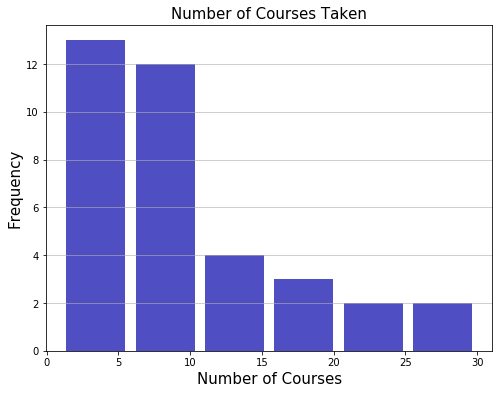

In [0]:
plt.figure(figsize=[8,6])
print("Mean: ", np.mean(temp['PIDM'].value_counts().tolist()))
n, bins, patches = plt.hist(temp['PIDM'].value_counts().tolist(), bins=6, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of Courses',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Number of Courses Taken',fontsize=15)
plt.savefig("NumCourses.png")
plt.show()

Mean:  1.8888888888888888
921836    4
929893    3
820546    2
688330    2
720610    2
772505    1
648344    1
935314    1
658793    1
Name: PIDM, dtype: int64


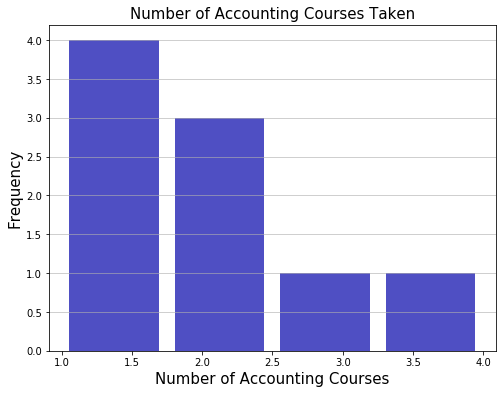

In [0]:
plt.figure(figsize=[8,6])
print("Mean: ", np.mean(temp[temp['Disc'] == "ACC"]['PIDM'].value_counts()))
print(temp[temp['Disc'] == "ACC"]['PIDM'].value_counts())
n, bins, patches = plt.hist(temp[temp['Disc'] == "ACC"]['PIDM'].value_counts().tolist(), bins=4, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of Accounting Courses',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Number of Accounting Courses Taken',fontsize=15)
plt.savefig("NumCourses.png")
plt.show()

In [0]:
print(Counter(temp[temp['Disc'] == "ACC"]['GradeX']))
print(Counter(temp[temp['Disc'] == "ACC"]['CourseInfo']))
print(Counter(temp[temp['CourseInfo'] == "ACC111"]['GradeX']))
print(Counter(temp[temp['CourseInfo'] == "ACC131"]['GradeX']))

Counter({'A': 4, 'B-': 3, 'W': 3, 'B+': 3, 'F': 2, 'A-': 1, 'B': 1})
Counter({'ACC111': 7, 'ACC131': 5, 'ACC122': 2, 'ACC110': 2, 'ACC100': 1})
Counter({'B+': 2, 'B-': 1, 'W': 1, 'A': 1, 'F': 1, 'A-': 1})
Counter({'W': 2, 'A': 2, 'B-': 1})


- **Conclusion for dropout Accounting certificate program candidates**: 
  - These students declared their certificate major at least six years ago and did not take accounting courses in recent three years. The average number of courses they have taken is around 9 but accounting courses no more than 2 on average. More importantly, all these accounting courses taken are 100-level.
  - There are 36 students that declared major ACCB but only 12 of them took ACC courses.

In [0]:
# Use Accounting courses and its grades to do the clustering 
# tell the most traditional pattern for ACC courses of these drop-out students
print(len(ACCB_declare_nograduate))
temp =temp[temp['Disc'] == "ACC"]
print("unique PIDM for those who have taken ACC courses: ", len(temp['PIDM'].unique()))
temp['Course+Grade'] = temp['CourseInfo'] + temp['GradeX']
temp['Course+Grade'].unique()
print(len(temp))
temp = pd.get_dummies(temp[['PIDM', 'Course+Grade']], prefix='g').groupby(level=0).sum()
print(len(temp))
temp

36
unique PIDM for those who have taken ACC courses:  9
17
17


,PIDM,g_ACC100F,g_ACC110A,g_ACC110B+,g_ACC111A,g_ACC111A-,g_ACC111B+,g_ACC111B-,g_ACC111F,g_ACC111W,g_ACC122B,g_ACC122B-,g_ACC131A,g_ACC131B-,g_ACC131W
73519,648344,0,0,0,0,0,0,0,0,0,0,0,0,0,1
76136,658793,0,0,0,0,0,0,0,0,1,0,0,0,0,0
95978,720610,0,0,0,1,0,0,0,0,0,0,0,0,0,0
95979,720610,0,0,0,0,0,0,0,0,0,0,0,1,0,0
119685,772505,0,1,0,0,0,0,0,0,0,0,0,0,0,0
176301,820546,0,0,0,0,0,0,0,0,0,0,0,0,0,1
176302,820546,0,0,0,0,0,0,0,1,0,0,0,0,0,0
506408,921836,1,0,0,0,0,0,0,0,0,0,0,0,0,0
506410,921836,0,0,0,0,0,1,0,0,0,0,0,0,0,0
506412,921836,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [0]:
# sum up for further clustering
temp = temp.groupby("PIDM").sum()
temp

,g_ACC100F,g_ACC110A,g_ACC110B+,g_ACC111A,g_ACC111A-,g_ACC111B+,g_ACC111B-,g_ACC111F,g_ACC111W,g_ACC122B,g_ACC122B-,g_ACC131A,g_ACC131B-,g_ACC131W
PIDM,,,,,,,,,,,,,,
648344,0,0,0,0,0,0,0,0,0,0,0,0,0,1
658793,0,0,0,0,0,0,0,0,1,0,0,0,0,0
688330,0,0,0,0,0,0,1,0,0,0,1,0,0,0
720610,0,0,0,1,0,0,0,0,0,0,0,1,0,0
772505,0,1,0,0,0,0,0,0,0,0,0,0,0,0
820546,0,0,0,0,0,0,0,1,0,0,0,0,0,1
921836,1,0,1,0,0,1,0,0,0,0,0,0,1,0
929893,0,0,0,0,1,0,0,0,0,1,0,1,0,0
935314,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

In [0]:
# K-means clustering initially
x = temp.iloc[:, [i for i in range(14)]].values
kmeans = KMeans(n_clusters=3)
y_kmeans = kmeans.fit_predict(x)
print(y_kmeans)
print(kmeans.cluster_centers_)

[1 1 1 0 1 1 2 0 1]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.00000000e-01
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  5.00000000e-01  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.38777878e-17  1.66666667e-01 -1.38777878e-17 -1.38777878e-17
  -1.38777878e-17  1.66666667e-01  1.66666667e-01  1.66666667e-01
   1.66666667e-01 -1.38777878e-17  1.66666667e-01 -2.77555756e-17
  -1.38777878e-17  3.33333333e-01]
 [ 1.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00]]


In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf

,principal component 1,principal component 2,principal component 3
0,-0.182119,-0.597303,-0.404864
1,-0.103595,-0.193643,0.203020
2,-0.153549,-0.360056,1.149760
3,-0.538244,0.602176,-0.045249
4,-0.103595,-0.193643,0.203020
5,-0.241367,-0.873369,-0.738239
6,1.677962,0.471762,-0.172318
7,-0.797787,1.119676,-0.256259
8,0.442294,0.024400,0.061129


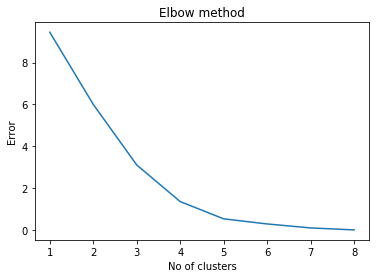

In [0]:
pca_x = principalDf.iloc[:, [i for i in range(3)]].values
Error =[]
for i in range(1, 9):
    kmeans = KMeans(n_clusters = i).fit(pca_x)
    kmeans.fit(pca_x)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 9), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.savefig("elbow.png")
plt.show()

In [0]:
kmeans = KMeans(n_clusters=3)
y_kmeans = kmeans.fit_predict(pca_x)
print(y_kmeans)
print(kmeans.cluster_centers_)

[1 1 1 0 1 1 2 0 1]
[[-0.66801521  0.8609259  -0.15075391]
 [-0.05698859 -0.36560226  0.078971  ]
 [ 1.67796197  0.47176176 -0.17231817]]


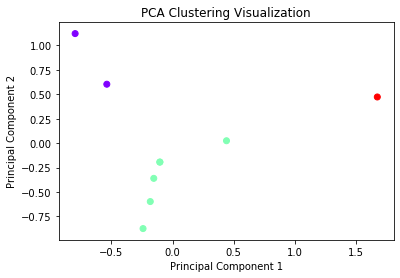

In [0]:
# visualization
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=y_kmeans, cmap='rainbow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Clustering Visualization')
plt.savefig("clusters.png")

In [0]:
# find patterns for each cluster
temp['cluster'] = y_kmeans
temp[temp['cluster'] == 0]

,g_ACC100F,g_ACC110A,g_ACC110B+,g_ACC111A,g_ACC111A-,g_ACC111B+,g_ACC111B-,g_ACC111F,g_ACC111W,g_ACC122B,g_ACC122B-,g_ACC131A,g_ACC131B-,g_ACC131W,cluster
PIDM,,,,,,,,,,,,,,,
720610,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
929893,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0


#### **Conclusion from clustering result**
- Basically, there are 4 clusters for drop-out ACCB students:
  - Those who took relatively more courses (>=4) but got bad scores (<=B+) (num sample = 1)
  - Those who took one ACC course or at most two ACC courses but got bad scores (B-, B+, F, W) (num sample = 6)
  - Those who took 2 or 3 courses but on average they got around A or A- in these courses (sample size is too small == 2)

In [0]:
# ACCT dropout next
temp = tblGrades[(tblGrades['PIDM'].isin(ACCT_declare_nograduate)) & (tblGrades['Term'] < 201609)]
temp['SucOrNot'] = 0
temp.SucOrNot[temp['GradeX'].isin(passSet)] = 1
temp['CourseInfo'] = temp.Disc.str.cat(temp.Num)
temp= temp.drop_duplicates(subset= ["PIDM", "SucOrNot", "CourseInfo"], keep='last')
temp.head(5)

,Download,PIDM,Term,CRN,Level,Div,Dept,Disc,Num,Sect,GradeX,Grade,Credit,SucOrNot,CourseInfo
432762,4/13/2001 0:00:00,186672,199801,CN001,NC,CED,CEDD,HEC,CE15,NaN,NG,NG,0.0,0,HECCE15
432763,2/18/2013 0:00:00,186672,200801,10100,CR,BCT,BUSD,ACC,111,06,F,F,3.0,0,ACC111
432764,2/18/2013 0:00:00,186672,200801,10139,CR,BCT,BUSD,TAX,101,02,W,W,3.0,0,TAX101
432765,2/18/2013 0:00:00,186672,200801,11061,CR,BCT,CISD,CIS,100,19X,W,W,3.0,0,CIS100
432766,2/18/2013 0:00:00,186672,200801,13353,CR,BCT,BUSD,ACC,122,05X,W,W,3.0,0,ACC122


Mean:  9.553516819571865


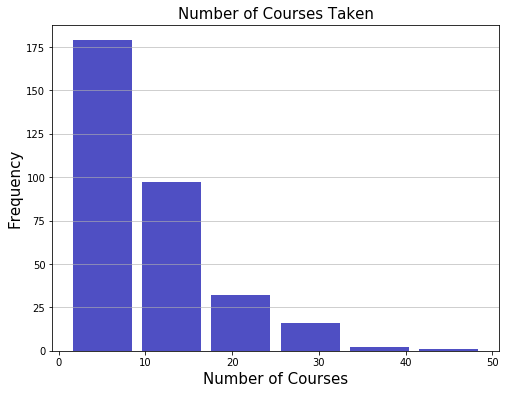

In [0]:
plt.figure(figsize=[8,6])
print("Mean: ", np.mean(temp['PIDM'].value_counts().tolist()))
n, bins, patches = plt.hist(temp['PIDM'].value_counts().tolist(), bins=6, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of Courses',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Number of Courses Taken',fontsize=15)
plt.savefig("NumCourses.png")
plt.show()

Mean:  1.9365079365079365
665850    7
901611    6
899556    6
896874    6
897950    5
         ..
704415    1
706981    1
875183    1
863664    1
703097    1
Name: PIDM, Length: 126, dtype: int64


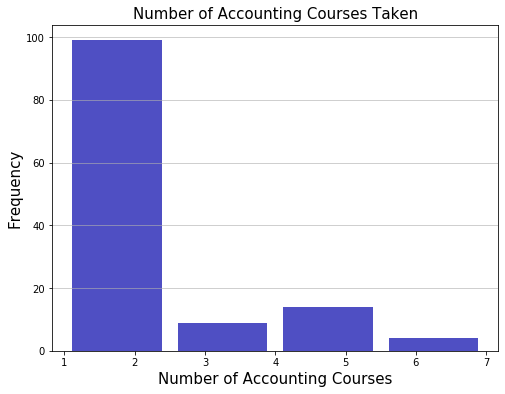

In [0]:
plt.figure(figsize=[8,6])
print("Mean: ", np.mean(temp[temp['Disc'] == "ACC"]['PIDM'].value_counts()))
print(temp[temp['Disc'] == "ACC"]['PIDM'].value_counts())
n, bins, patches = plt.hist(temp[temp['Disc'] == "ACC"]['PIDM'].value_counts().tolist(), bins=4, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of Accounting Courses',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Number of Accounting Courses Taken',fontsize=15)
plt.savefig("NumCourses.png")
plt.show()

In [0]:
print(Counter(temp[temp['Disc'] == "ACC"]['GradeX']))
print(Counter(temp[temp['Disc'] == "ACC"]['CourseInfo']))
print(Counter(temp[temp['CourseInfo'] == "ACC111"]['GradeX']))
print(Counter(temp[temp['CourseInfo'] == "ACC131"]['GradeX']))

Counter({'A': 88, 'F': 35, 'W': 30, 'B': 23, 'B+': 15, 'C': 13, 'A-': 11, 'C+': 7, 'D': 7, 'D+': 4, 'C-': 3, 'N': 3, 'B-': 3, 'D-': 2})
Counter({'ACC111': 119, 'ACC122': 50, 'ACC131': 42, 'ACC213': 11, 'ACC110': 10, 'ACC225': 8, 'ACC100': 4})
Counter({'A': 47, 'F': 17, 'W': 14, 'B': 10, 'C': 7, 'B+': 5, 'A-': 5, 'C+': 4, 'N': 3, 'D': 3, 'C-': 2, 'D+': 1, 'B-': 1})
Counter({'A': 14, 'W': 6, 'B': 6, 'F': 5, 'A-': 3, 'B-': 2, 'C+': 1, 'C': 1, 'D-': 1, 'D+': 1, 'D': 1, 'B+': 1})


- **Conclusion for dropout Accounting Associate Degree program candidates**: 
  - These students declared their Associate Degree major at least six years ago and did not take accounting courses in recent three years. The average number of courses they have taken is around 9 but accounting courses around 2 on average. More importantly, most of these accounting courses taken are 100-level.
  - There are 326 students that declared major ACCB but only 123 of them took ACC courses.

In [0]:
# Use Accounting courses and its grades to do the clustering 
# tell the most traditional pattern for ACC courses of these drop-out students
print(len(ACCT_declare_nograduate))
temp =temp[temp['Disc'] == "ACC"]
print("unique PIDM for those who have taken ACC courses: ", len(temp['PIDM'].unique()))
temp['Course+Grade'] = temp['CourseInfo'] + temp['GradeX']
temp['Course+Grade'].unique()
print(len(temp))
temp = pd.get_dummies(temp[['PIDM', 'Course+Grade']], prefix='g').groupby(level=0).sum()
print(len(temp))
temp

327
unique PIDM for those who have taken ACC courses:  126
244
244


,PIDM,g_ACC100D,g_ACC100F,g_ACC100W,g_ACC110A,g_ACC110A-,g_ACC110B+,g_ACC110C,g_ACC110F,g_ACC111A,g_ACC111A-,g_ACC111B,g_ACC111B+,g_ACC111B-,g_ACC111C,g_ACC111C+,g_ACC111C-,g_ACC111D,g_ACC111D+,g_ACC111F,g_ACC111N,g_ACC111W,g_ACC122A,g_ACC122A-,g_ACC122B,g_ACC122B+,g_ACC122C,g_ACC122C+,g_ACC122C-,g_ACC122D,g_ACC122D+,g_ACC122F,g_ACC122W,g_ACC131A,g_ACC131A-,g_ACC131B,g_ACC131B+,g_ACC131B-,g_ACC131C,g_ACC131C+,g_ACC131D,g_ACC131D+,g_ACC131D-,g_ACC131F,g_ACC131W,g_ACC213A,g_ACC213B,g_ACC213B+,g_ACC213C+,g_ACC213D-,g_ACC213W,g_ACC225A,g_ACC225B,g_ACC225B+,g_ACC225C,g_ACC225D+,g_ACC225F
42409,536000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
52047,572472,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
53828,584761,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
72832,646634,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
78116,665850,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364636,833686,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1370100,834756,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1374456,836807,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1387658,840408,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# sum up for further clustering
temp = temp.groupby("PIDM").sum()
temp

,g_ACC100D,g_ACC100F,g_ACC100W,g_ACC110A,g_ACC110A-,g_ACC110B+,g_ACC110C,g_ACC110F,g_ACC111A,g_ACC111A-,g_ACC111B,g_ACC111B+,g_ACC111B-,g_ACC111C,g_ACC111C+,g_ACC111C-,g_ACC111D,g_ACC111D+,g_ACC111F,g_ACC111N,g_ACC111W,g_ACC122A,g_ACC122A-,g_ACC122B,g_ACC122B+,g_ACC122C,g_ACC122C+,g_ACC122C-,g_ACC122D,g_ACC122D+,g_ACC122F,g_ACC122W,g_ACC131A,g_ACC131A-,g_ACC131B,g_ACC131B+,g_ACC131B-,g_ACC131C,g_ACC131C+,g_ACC131D,g_ACC131D+,g_ACC131D-,g_ACC131F,g_ACC131W,g_ACC213A,g_ACC213B,g_ACC213B+,g_ACC213C+,g_ACC213D-,g_ACC213W,g_ACC225A,g_ACC225B,g_ACC225B+,g_ACC225C,g_ACC225D+,g_ACC225F
PIDM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
186672,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
522962,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
523090,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
527626,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
532269,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911874,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
912321,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
915594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# K-means clustering initially
x = temp.iloc[:, [i for i in range(56)]].values
kmeans = KMeans(n_clusters=3)
y_kmeans = kmeans.fit_predict(x)
print(y_kmeans)
print(kmeans.cluster_centers_)

[0 1 2 1 1 2 0 0 1 0 2 1 1 1 1 0 1 2 0 2 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 1 1 1 1 1 1 0 0 1 1 2 0 2 1 0 1 0 0 2 1 0 0 0 1 1 0 1 0 0 1 0 2 1 0
 1 1 0 2 0 0 1 1 0 0 0 0 0 0 1 2 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 1
 0 0 2 1 0 0 2 1 1 0 0 1 0 0 0]
[[ 1.49253731e-02  2.98507463e-02  1.49253731e-02  2.77555756e-17
   1.38777878e-17  2.98507463e-02  1.49253731e-02  4.47761194e-02
  -3.33066907e-16  7.46268657e-02  1.49253731e-01  5.97014925e-02
   1.49253731e-02  1.04477612e-01  5.97014925e-02  2.98507463e-02
   4.47761194e-02  1.49253731e-02  2.38805970e-01  4.47761194e-02
   1.66533454e-16  2.98507463e-02  1.49253731e-02  4.47761194e-02
   4.47761194e-02  4.47761194e-02  1.49253731e-02  1.38777878e-17
   2.98507463e-02  1.49253731e-02  4.47761194e-02  7.46268657e-02
   4.47761194e-02  2.98507463e-02  5.97014925e-02  1.38777878e-17
   2.98507463e-02  1.49253731e-02  1.49253731e-02  1.49253731e-02
   1.38777878e-17  1.49253731e-02  4.47761194e-02  7.46268657e-02
   5.55111512e-17

In [0]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf

,principal component 1,principal component 2,principal component 3
0,-0.567931,0.774019,-0.136699
1,0.729443,-0.125610,0.147712
2,0.351999,-0.546615,-0.863567
3,0.890460,0.142800,-0.072042
4,0.470642,-0.116049,-0.128693
...,...,...,...
121,-0.648985,1.024772,-0.288085
122,0.936207,0.161942,-0.084878
123,-0.332496,-0.102163,0.097211
124,-0.443545,-0.190858,0.199791


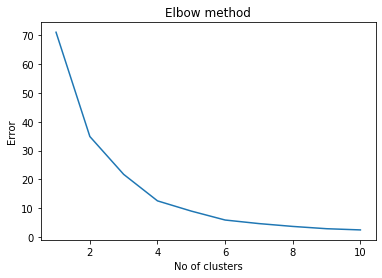

In [0]:
pca_x = principalDf.iloc[:, [i for i in range(3)]].values
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(pca_x)
    kmeans.fit(pca_x)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.savefig("elbow.png")
plt.show()

In [0]:
kmeans = KMeans(n_clusters=5)
y_kmeans = kmeans.fit_predict(pca_x)
print(y_kmeans)
print(kmeans.cluster_centers_)

[4 3 0 2 3 0 1 1 3 1 0 2 3 3 2 1 2 0 1 0 3 4 3 1 4 1 1 1 1 1 1 1 1 4 1 1 1
 0 1 1 3 2 3 3 3 3 1 4 3 2 0 1 0 3 1 2 1 1 0 2 1 1 1 3 3 1 2 1 1 3 4 0 3 1
 3 4 1 0 1 1 3 3 1 4 1 4 1 1 3 0 1 4 2 2 1 1 1 2 3 4 3 4 1 4 3 1 1 3 4 2 3
 1 1 0 2 4 4 0 2 2 1 4 2 1 1 1]
[[-0.34332681 -0.5529655  -0.59916598]
 [-0.36282872 -0.10486591  0.24419309]
 [ 1.02143621  0.17871891  0.04852966]
 [ 0.52575196 -0.11033262 -0.05811692]
 [-0.48522814  0.76649635 -0.19537479]]


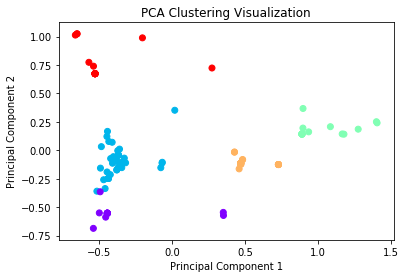

In [0]:
# visualization
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=y_kmeans, cmap='rainbow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Clustering Visualization')
plt.savefig("clusters.png")

In [0]:
# find patterns for each cluster
temp['cluster'] = y_kmeans
temp[temp['cluster'] == 4]

,g_ACC100D,g_ACC100F,g_ACC100W,g_ACC110A,g_ACC110A-,g_ACC110B+,g_ACC110C,g_ACC110F,g_ACC111A,g_ACC111A-,g_ACC111B,g_ACC111B+,g_ACC111B-,g_ACC111C,g_ACC111C+,g_ACC111C-,g_ACC111D,g_ACC111D+,g_ACC111F,g_ACC111N,g_ACC111W,g_ACC122A,g_ACC122A-,g_ACC122B,g_ACC122B+,g_ACC122C,g_ACC122C+,g_ACC122C-,g_ACC122D,g_ACC122D+,g_ACC122F,g_ACC122W,g_ACC131A,g_ACC131A-,g_ACC131B,g_ACC131B+,g_ACC131B-,g_ACC131C,g_ACC131C+,g_ACC131D,g_ACC131D+,g_ACC131D-,g_ACC131F,g_ACC131W,g_ACC213A,g_ACC213B,g_ACC213B+,g_ACC213C+,g_ACC213D-,g_ACC213W,g_ACC225A,g_ACC225B,g_ACC225B+,g_ACC225C,g_ACC225D+,g_ACC225F,cluster
PIDM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
186672,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
604781,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
622884,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
668037,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
725994,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4
819506,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
822529,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4
840155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
840810,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


#### **Conclusion from clustering result**
- Basically, there are 5 clusters for drop-out ACCT students:
  - Those who took ACC111 and drop directly (num sample = 14)
  - Those who took relatively more courses (>=3) but got bad scores (<=B+) (num sample = 51)
  - Those who took ACC111/ACC122 with A-level and got a lot of other ACC  courses with good grades (num sample = 17)
  - Those who took one ACC course - ACC111 and got A-level but didn't continue to attend other courses (num sample = 27)
  - Those who took one ACC course - ACC111 and got F-level (num sample = 17)

#### **Some addtional information to see**
- When did students take their first Accounting course after declaring ACC Major?

In [0]:
ACCT_graduate = tblAwards_ACCT['PIDM'].tolist()

col_names =  ['Graduate PIDM', 'First Declare Term', 'First ACC course taking Term']
my_df  = pd.DataFrame(columns = col_names)
for i in range(len(ACCT_graduate)):
  pidm = ACCT_graduate[i]
  temp_term1 = tblMergeX_combine[(tblMergeX_combine['Maj'] == "ACCT") & (tblMergeX_combine['PIDM'] == pidm)]
  if len(temp_term1) > 0:
    declare_term = min(temp_term1['RegTerm'])
    temp_term2 = tblGrades[(tblGrades['PIDM'] == pidm) & (tblGrades['Disc'] == "ACC")]
    if len(temp_term2) > 0:
      acc_term = min(temp_term2['Term'])
      my_df.loc[len(my_df)] = [pidm, declare_term, acc_term]
my_df.head(20)

,Graduate PIDM,First Declare Term,First ACC course taking Term
0,589070,200201,200205
1,550546,200101,200105
2,556922,200205,200109
3,603042,200205,200205
4,527785,200105,200209
5,537035,200009,200009
6,590145,200301,200301
7,614872,200309,200309
8,656264,200309,200309
9,173623,200301,200401


In [0]:
my_df['Time lag'] = my_df['First ACC course taking Term'] - my_df['First Declare Term']
my_df[my_df['Time lag'] >= 0]['Time lag'].value_counts()
# total number: 152
# 50% - declare then start immediately
# 10% - declare then start within two semesters
# 33% - declare then start within two years
# 17% - declare then start within four years

0      70
100    22
92     16
4       9
8       8
96      7
192     5
104     3
200     3
400     2
704     1
292     1
396     1
392     1
108     1
408     1
208     1
Name: Time lag, dtype: int64

In [0]:
ACCB_graduate = tblAwards_ACCB['PIDM'].tolist()

col_names =  ['Graduate PIDM', 'First Declare Term', 'First ACC course taking Term']
my_df  = pd.DataFrame(columns = col_names)
for i in range(len(ACCB_graduate)):
  pidm = ACCB_graduate[i]
  temp_term1 = tblMergeX_combine[(tblMergeX_combine['Maj'] == "ACCB") & (tblMergeX_combine['PIDM'] == pidm)]
  if len(temp_term1) > 0:
    declare_term = min(temp_term1['RegTerm'])
    temp_term2 = tblGrades[(tblGrades['PIDM'] == pidm) & (tblGrades['Disc'] == "ACC")]
    if len(temp_term2) > 0:
      acc_term = min(temp_term2['Term'])
      my_df.loc[len(my_df)] = [pidm, declare_term, acc_term]
my_df.head(20)

,Graduate PIDM,First Declare Term,First ACC course taking Term
0,886190,201309,201201
1,917884,201305,201309
2,501922,201309,200905
3,642468,201301,201309
4,811395,201301,201301
5,881895,201305,201209
6,906105,201309,201309
7,901069,201309,201309
8,905759,201309,201409
9,911725,201409,201501


In [0]:
my_df['Time lag'] = my_df['First ACC course taking Term'] - my_df['First Declare Term']
my_df[my_df['Time lag'] >= 0]['Time lag'].value_counts()
# total 38
# 37% - declare then start immediately
# 60% - declare then start within two semesters
# 3% - declare then start within two years

0      14
92      4
100     4
4       2
196     1
108     1
8       1
104     1
Name: Time lag, dtype: int64

In [0]:
print(len(ACCT_graduate))
print(len(ACCB_graduate))

227
134


In [0]:
17/126

0.1349206349206349

##### **Other Major graduates courses taking pattern**

In [0]:
from collections import Counter
from itertools import combinations

In [0]:
temp_list = []
length_temp_list = []
for pidm in ACCT_PIDM:
  temp = ACCT_course[(ACCT_course['PIDM'] == pidm) & (ACCT_course['Disc'] == "ACC") & (ACCT_course['SucOrNot'] == 1)]["CourseInfo"].tolist()
  if temp == []:
    print(pidm)
  temp_list.append(temp)
  length_temp_list.append(len(temp))
print(len(temp_list))

73812
199


In [0]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

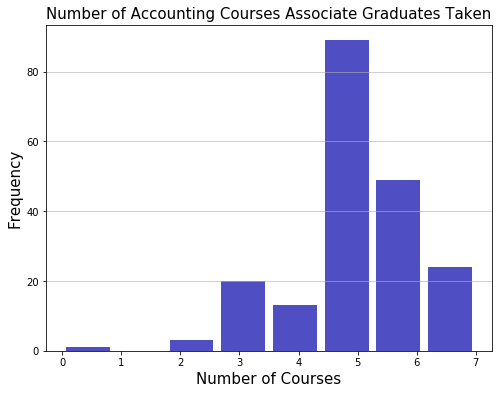

In [0]:
plt.figure(figsize=[8,6])
n, bins, patches = plt.hist(length_temp_list, bins=8, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of Courses',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Number of Accounting Courses Associate Graduates Taken',fontsize=15)
plt.savefig("NumCourses.png")
plt.show()

In [0]:
d  = Counter()
for sub in temp_list:
    if len(temp_list) < 5:
        continue
    sub.sort()
    for comb in combinations(sub, 5):
        d[comb] += 1
print(d.most_common())

[(('ACC111', 'ACC122', 'ACC131', 'ACC213', 'ACC225'), 154), (('ACC110', 'ACC111', 'ACC122', 'ACC131', 'ACC213'), 74), (('ACC110', 'ACC111', 'ACC122', 'ACC131', 'ACC225'), 72), (('ACC110', 'ACC111', 'ACC122', 'ACC213', 'ACC225'), 72), (('ACC110', 'ACC122', 'ACC131', 'ACC213', 'ACC225'), 72), (('ACC110', 'ACC111', 'ACC131', 'ACC213', 'ACC225'), 71), (('ACC110', 'ACC122', 'ACC213', 'ACC214', 'ACC225'), 24), (('ACC110', 'ACC131', 'ACC213', 'ACC214', 'ACC225'), 24), (('ACC110', 'ACC111', 'ACC122', 'ACC131', 'ACC214'), 23), (('ACC110', 'ACC111', 'ACC122', 'ACC213', 'ACC214'), 23), (('ACC110', 'ACC111', 'ACC122', 'ACC214', 'ACC225'), 23), (('ACC110', 'ACC111', 'ACC131', 'ACC213', 'ACC214'), 23), (('ACC110', 'ACC111', 'ACC131', 'ACC214', 'ACC225'), 23), (('ACC110', 'ACC111', 'ACC213', 'ACC214', 'ACC225'), 23), (('ACC110', 'ACC122', 'ACC131', 'ACC213', 'ACC214'), 23), (('ACC110', 'ACC122', 'ACC131', 'ACC214', 'ACC225'), 23), (('ACC111', 'ACC122', 'ACC131', 'ACC213', 'ACC214'), 23), (('ACC111', 